# Football Match Prediction with Hierarchical Bayesian Models
## Analyzing Argentine League Performance (2024-2025)

## 1. Setup and Configuration

In [1]:
# %%
# Import libraries
import os
import sys
import io
import itertools
from pathlib import Path
from typing import Tuple, Dict, Optional

import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import plotnine as p9
from plotnine import *
import pymc as pm
import arviz as az
import pytensor.tensor as pt
import plotly.graph_objects as go
import plotly

from scripts.helpers import make_1x2_calib_data, format_season_df, forward_model, scrape_fbref_data

# Jupyter magic commands
%load_ext autoreload
%autoreload 2
%load_ext watermark
%watermark --iversions

# Configuration
theme_set(theme_bw())
pd.set_option('display.max_columns', 100)
SEED = 1994
PROJECT_DIR = Path('..')
LOCAL_DATA_DIR = PROJECT_DIR / 'data'

# %% [markdown]
# ## 2. Helper Classes

pymc      : 5.20.1
matplotlib: 3.10.1
pandas    : 2.2.3
bs4       : 0.0.2
requests  : 2.32.3
plotly    : 6.0.1
numpy     : 1.26.4
sys       : 3.11.8 | packaged by conda-forge | (main, Feb 16 2024, 20:49:36) [Clang 16.0.6 ]
arviz     : 0.21.0
pytensor  : 2.27.1
plotnine  : 0.14.5



In [2]:
class FBrefScraper:
    """Class for scraping football data from FBref.com"""
    
    @staticmethod
    def scrape_fbref_data(url: str) -> Tuple[str, BeautifulSoup]:
        """Scrape data from FBref website."""
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }
        response = requests.get(url, headers=headers)
        soup = BeautifulSoup(response.text, 'html.parser')
        season_id = url.split('/')[-2]
        return season_id, soup

class DataPreprocessor:
    """Class for preprocessing football match data"""
    
    @staticmethod
    def prepare_model_inputs(df: pd.DataFrame) -> Tuple[int, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """Prepare numpy arrays for model inputs."""
        n_teams = df['hg'].nunique()
        home_idx = df['hg'].values
        away_idx = df['ag'].values
        home_goals = df['yg1'].values
        away_goals = df['yg2'].values
        
        print(f'n_teams: {n_teams}')
        print(f'home team indices (home_idx): {home_idx[0:5]}...')
        print(f'away team indices (away_idx): {away_idx[0:5]}...')
        print(f'home goals: {home_goals[0:5]}...')
        print(f'away goals: {away_goals[0:5]}...')
        
        return n_teams, home_idx, away_idx, home_goals, away_goals

class HierarchicalModel:
    """Class for building and analyzing hierarchical Bayesian models for football results"""
    
    def __init__(self, n_teams: int, home_idx: np.ndarray, away_idx: np.ndarray, home_goals: np.ndarray, away_goals: np.ndarray):
        """Initialize the model with basic parameters."""
        self.n_teams = n_teams
        self.home_idx = home_idx
        self.away_idx = away_idx
        self.home_goals  = home_goals   # now defined before build_model
        self.away_goals  = away_goals
        self.model = None
        self.idata = None
        
    def build_model(self) -> pm.Model:
        """Build the hierarchical Bayesian model."""
        with pm.Model() as self.model:
            # Hyper-priors
            mu_att = pm.Normal('mu_att', mu=2.0, sigma=1.0)
            sigma_att = pm.HalfNormal('sigma_att', sigma=1.0)    
            mu_def = pm.Normal('mu_def', mu=-2.0, sigma=1.0)
            sigma_def = pm.HalfNormal('sigma_def', sigma=1.0)

            # Non-centered parameterization
            att_t_ = pm.Normal("att_t_", 0, 1, shape=self.n_teams)
            def_t_ = pm.Normal('def_t_', 0, 1, shape=self.n_teams)

            # Priors
            home = pm.Normal("home", mu=0.5, sigma=0.5/3)
            
            # Transformed parameters
            att_t = pm.Deterministic('att_t', mu_att + att_t_ * sigma_att)
            def_t = pm.Deterministic('def_t', mu_def + def_t_ * sigma_def)
            
            # Zero sum constraint
            att_t_adj = pm.Deterministic("att_t_adj", att_t - pt.mean(att_t))
            def_t_adj = pm.Deterministic('def_t_adj', def_t - pt.mean(def_t))

            # Log linear random effect model
            theta_home = pm.Deterministic('theta_home', 
                                         pt.exp(home + att_t_adj[self.home_idx] - def_t_adj[self.away_idx]))
            theta_away = pm.Deterministic('theta_away', 
                                         pt.exp(att_t_adj[self.away_idx] - def_t_adj[self.home_idx]))
            
            # Likelihood
            self.home_goalsl = pm.Poisson('home_goalsl', mu=theta_home, observed=self.home_goals)
            self.away_goalsl = pm.Poisson('away_goalsl', mu=theta_away, observed=self.away_goals)
        
        return self.model
    
    def fit_model(self) -> az.InferenceData:
        """Fit the model to data."""
        with self.model:
            self.idata = pm.sample_prior_predictive()
            self.idata.extend(pm.sample(idata_kwargs={'log_likelihood': True}))
            pm.sample_posterior_predictive(trace=self.idata, extend_inferencedata=True)
        return self.idata
    
    def calculate_match_probs(self, df: pd.DataFrame) -> pd.DataFrame:
        """Calculate match outcome probabilities from model results."""
        home_goals_df = self.idata.posterior_predictive['home_goalsl'].to_dataframe()
        away_goals_df = self.idata.posterior_predictive['away_goalsl'].to_dataframe()
        
        scores_df = pd.concat([home_goals_df, away_goals_df], axis=1).droplevel((0,1), axis=0).reset_index().rename(columns={'index': 'game_num'})

        game_probs = []
        for game_num, game_df in scores_df.groupby(by=['game_num']):
            p_hwin = (game_df['home_goalsl'] > game_df['away_goalsl']).sum() / len(game_df)
            p_draw = (game_df['home_goalsl'] == game_df['away_goalsl']).sum() / len(game_df)
            p_awin = (game_df['home_goalsl'] < game_df['away_goalsl']).sum() / len(game_df)
            game_probs.append(pd.DataFrame({'p(hwin)pred': [p_hwin], 'p(draw)pred': [p_draw], 'p(awin)pred': [p_awin]}, index=game_num))
        
        probs_df = pd.concat(game_probs, axis=0)
        df_res = pd.concat([df, probs_df, pd.get_dummies(df['result']).astype(int)], axis=1)
        
        return df_res
    
    def plot_trace(self) -> None:
        """Plot trace plots for model diagnostics."""
        az.plot_trace(self.idata, var_names=['^home$', 'att', 'def'], 
                     filter_vars='regex', figsize=(12, 18))
        plt.suptitle('Model Trace Plots')
        plt.tight_layout()
        plt.show()
    
    def plot_team_strengths(self, team_dict: Dict[str, int]) -> go.Figure:
        """Create scatterplot of team strengths."""
        summ = az.summary(self.idata, hdi_prob=0.95).round(2)
        att_effect = summ.filter(regex='att_t_adj', axis=0)['mean'].rename('mean_attack_effect').reset_index(drop=True)
        def_effect = summ.filter(regex='def_t_adj', axis=0)['mean'].rename('mean_defence_effect').reset_index(drop=True)
        hier_effects = pd.concat([att_effect, def_effect], axis=1)
        hier_effects.index = list(team_dict.keys())

        fig = go.Figure()
        fig.add_trace(go.Scatter(
            x=hier_effects['mean_attack_effect'],
            y=hier_effects['mean_defence_effect'],
            mode='markers+text',
            name='Team Strengths',
            marker=dict(color='blue', size=10),
            text=hier_effects.index,
            textposition="bottom center",
            textfont=dict(size=10))
        )

        fig.add_hline(y=0, line_width=1, line_dash="dash", line_color="gray", opacity=0.25)
        fig.add_vline(x=0, line_width=1, line_dash="dash", line_color="gray", opacity=0.25)

        fig.update_layout(
            title='Team Strength Analysis<br>Attack vs Defense Effects',
            xaxis_title='Mean Attack Effect',
            yaxis_title='Mean Defence Effect',
            showlegend=True,
            width=1000,
            height=800,
            plot_bgcolor='white',
            legend=dict(yanchor="top", y=0.99, xanchor="right", x=0.99))
            
        fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')
        fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')

        return fig

class ModelEvaluator:
    """Class for evaluating model performance"""
    
    @staticmethod
    def plot_reliability(df_res: pd.DataFrame, n_bins: int = 10, strategy: str = 'quantile') -> p9.ggplot:
        """Create reliability plots for model evaluation."""
        pred_cols = ['p(hwin)pred', 'p(draw)pred', 'p(awin)pred']
        n_matches = len(df_res)
        cal_df = make_1x2_calib_data(df_res, n_bins=n_bins, strategy=strategy, pred_cols=pred_cols)

        p = (ggplot(cal_df, aes(x='mean_predicted_proba', y='mean_actual_proba', group='calib')) +
             geom_point(fill='none') +
             geom_abline(intercept=0, slope=1, alpha=0.5, linetype='dashed') +
             coord_cartesian(xlim=(0, 1.0), ylim=(0, 1.0)) +
             labs(x='mean predicted probability',
                  y='mean actual probability',
                  title=f'Reliability Plots\n{n_matches} matches - {n_bins} {strategy} bins') +
             facet_wrap('calib') +
             theme(figure_size=(9,4)))
        return p

# %% [markdown]
# ## 3. Data Loading Functions

# %%
def load_data(filepath: Optional[str] = None, url: Optional[str] = None) -> Tuple[pd.DataFrame, pd.DataFrame, Dict[str, int]]:
    """Load and prepare football match data from either file or URL."""
    if filepath:
        df = pd.read_csv(filepath)
    elif url:
        season_id, soup = FBrefScraper.scrape_fbref_data(url)
        table = soup.select("#sched_all")[0]
        df = pd.read_html(io.StringIO(str(table)))[0]
        df.dropna(subset=['Score'], inplace=True)
        if 'Round' in df.columns:
            df = df.loc[df['Round'] == 'Torneo Apertura — Regular season']
    else:
        raise ValueError("Either filepath or url must be provided")
    
    # Process data
    df['h_ftgoals'] = df['Score'].str.split('–').str[0].astype(int)
    df['a_ftgoals'] = df['Score'].str.split('–').str[1].astype(int)
    df = df[['Wk', 'Day', 'Date', 'Home', 'Away', 'h_ftgoals', 'a_ftgoals']]
    
    # Format for modeling
    formatted_df, team_dict = format_season_df(df.copy())
    
    return df, formatted_df, team_dict


n_teams: 28
home team indices (home_idx): [23 17  0 20 14]...
away team indices (away_idx): [15 18 21  6 24]...
home goals: [1 2 3 3 1]...
away goals: [2 0 2 0 3]...


Sampling: [att_t_, away_goalsl, def_t_, home, home_goalsl, mu_att, mu_def, sigma_att, sigma_def]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_att, sigma_att, mu_def, sigma_def, att_t_, def_t_, home]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
Sampling: [away_goalsl, home_goalsl]


Output()

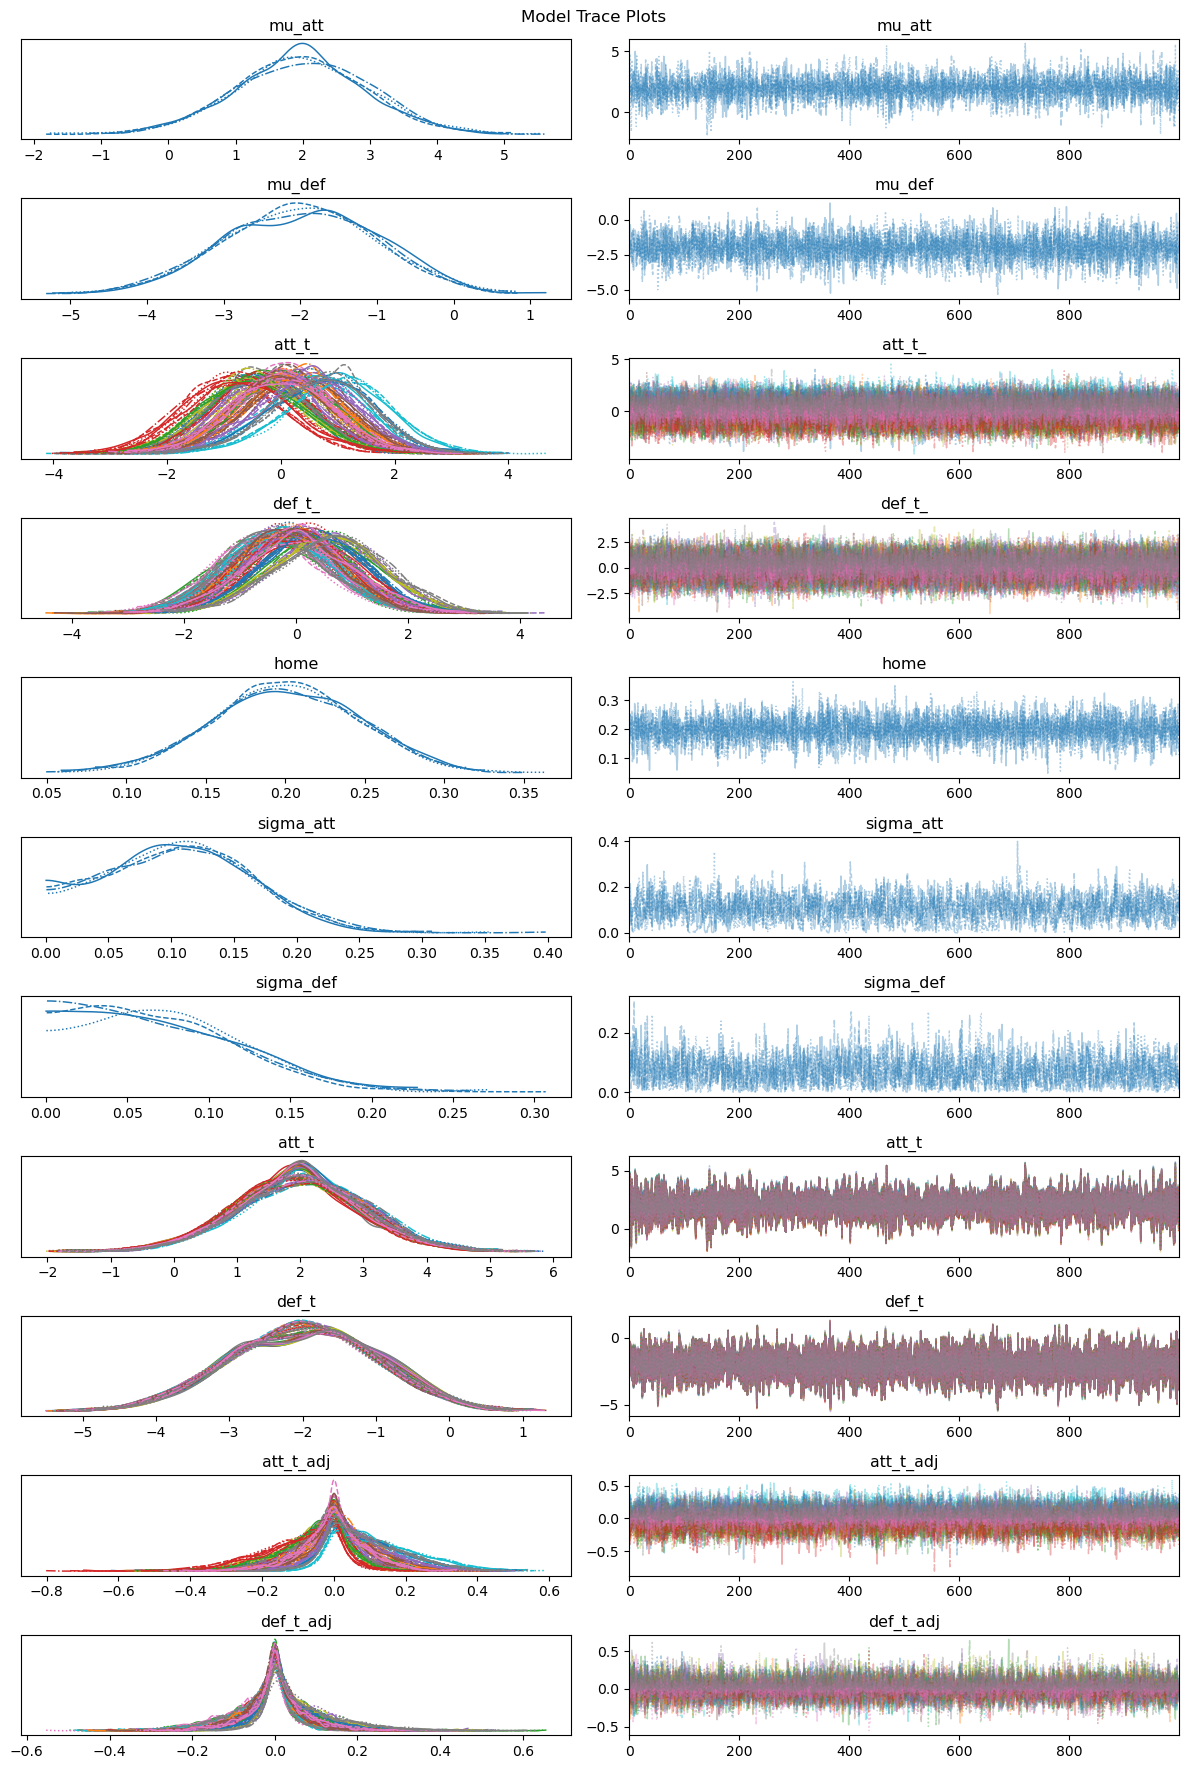

,g,home,away,hg,ag,yg1,yg2,result,p(hwin)pred,p(draw)pred,p(awin)pred,awin,draw,hwin
13,13,Gimnasia–LP,Vélez Sarsfield,10,27,3,1,hwin,0.36350,0.28800,0.34850,0,0,1
27,27,Vélez Sarsfield,Newell's OB,27,17,1,0,hwin,0.48925,0.26175,0.24900,0,0,1
36,36,Independiente,Vélez Sarsfield,14,27,1,1,draw,0.38600,0.28850,0.32550,0,1,0
41,41,Vélez Sarsfield,Atlé Tucumán,27,1,1,1,draw,0.45475,0.28325,0.26200,0,1,0
65,65,Boca Juniors,Vélez Sarsfield,5,27,1,0,hwin,0.38900,0.28125,0.32975,0,0,1
78,78,Vélez Sarsfield,Talleres,27,24,3,0,hwin,0.45325,0.27025,0.27650,0,0,1
92,92,Platense,Vélez Sarsfield,18,27,0,2,awin,0.36450,0.29500,0.34050,1,0,0
105,105,Cen. Córdoba–SdE,Vélez Sarsfield,6,27,0,2,awin,0.36525,0.28125,0.35350,1,0,0
112,112,Vélez Sarsfield,Defensa y Just,27,7,3,0,hwin,0.46400,0.27050,0.26550,0,0,1
137,137,Banfield,Vélez Sarsfield,2,27,2,2,draw,0.35225,0.28825,0.35950,0,1,0


In [3]:
# %% [markdown]
# ## 4. 2024 Argentine League Analysis

# %%
# Load and prepare 2024 data
df_raw_2024, df_formatted_2024, team_dict_2024 = load_data(
    filepath="2024-Liga-Profesional-Argentina-Scores-and-Fixtures.csv"
)

# Prepare model inputs
n_teams_2024, home_idx_2024, away_idx_2024, home_goals_2024, away_goals_2024 = DataPreprocessor.prepare_model_inputs(df_formatted_2024)

# Build and fit model
model_2024 = HierarchicalModel(n_teams_2024, home_idx_2024, away_idx_2024,home_goals_2024, away_goals_2024)
model_2024.build_model()
pm.model_to_graphviz(model_2024.model)

idata_2024 = model_2024.fit_model()

# Diagnostics
model_2024.plot_trace()

# Analyze results
df_res_2024 = model_2024.calculate_match_probs(df_formatted_2024)

# Model evaluation
p = ModelEvaluator.plot_reliability(df_res_2024)
plt.close()
p.draw()

# Team strength visualization
fig = model_2024.plot_team_strengths(team_dict_2024)
fig.update_layout(title='2024 LPF - Fortalezas de los equipos')
fig.show()

# Vélez Sarsfield specific analysis
df_res_2024.loc[(df_res_2024['home'] == 'Vélez Sarsfield') | (df_res_2024['away'] == 'Vélez Sarsfield')]



In [5]:
# %% [markdown]
# ## 5. 2025 Copa de la Liga Analysis

# %%
# Load and prepare 2025 data
_, df_formatted_2025, team_dict_2025 = load_data(
    url="https://fbref.com/en/comps/21/schedule/Liga-Profesional-Argentina-Scores-and-Fixtures"
)

# Prepare model inputs
n_teams_2025, home_idx_2025, away_idx_2025, home_goals_2025, away_goals_2025 = DataPreprocessor.prepare_model_inputs(df_formatted_2025)

# Build and fit model
model_2025 = HierarchicalModel(n_teams_2025, home_idx_2025, away_idx_2025, home_goals_2025, away_goals_2025)
model_2025.build_model()
idata_2025 = model_2025.fit_model()

# Analyze results
df_res_2025 = model_2025.calculate_match_probs(df_formatted_2025)

# Model evaluation
p = ModelEvaluator.plot_reliability(df_res_2025)
plt.close()
p.draw()

# Team strength visualization
fig = model_2025.plot_team_strengths(team_dict_2025)
fig.update_layout(title='2025 Copa de la Liga - Fortalezas de los equipos')
fig.show()

# Vélez Sarsfield specific analysis
df_res_2025.loc[(df_res_2025['home'] == 'Vélez Sarsfield') | (df_res_2025['away'] == 'Vélez Sarsfield')]

Sampling: [att_t_, away_goalsl, def_t_, home, home_goalsl, mu_att, mu_def, sigma_att, sigma_def]


n_teams: 30
home team indices (home_idx): [27 18 17 12  8]...
away team indices (away_idx): [29 14  9 22  3]...
home goals: [3 0 0 0 0]...
away goals: [0 1 2 3 1]...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_att, sigma_att, mu_def, sigma_def, att_t_, def_t_, home]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
Sampling: [away_goalsl, home_goalsl]


Output()

,g,home,away,hg,ag,yg1,yg2,result,p(hwin)pred,p(draw)pred,p(awin)pred,awin,draw,hwin
0,0,Tigre,Vélez Sarsfield,27,29,3,0,hwin,0.50775,0.27500,0.21725,0,0,1
16,16,Vélez Sarsfield,Platense,29,19,0,1,awin,0.31575,0.30825,0.37600,1,0,0
35,35,Instituto,Vélez Sarsfield,16,29,2,0,hwin,0.47025,0.27475,0.25500,0,0,1
51,51,Vélez Sarsfield,San Lorenzo,29,23,0,0,draw,0.32700,0.29500,0.37800,0,1,0
65,65,Independiente,Vélez Sarsfield,15,29,3,0,hwin,0.54275,0.25775,0.19950,0,0,1
84,84,Vélez Sarsfield,Godoy Cruz,29,12,0,2,awin,0.37900,0.30700,0.31400,1,0,0
89,89,Lanús,Vélez Sarsfield,17,29,0,0,draw,0.47600,0.29050,0.23350,0,1,0
110,110,Vélez Sarsfield,Huracán,29,13,0,2,awin,0.29625,0.28575,0.41800,1,0,0
118,118,Vélez Sarsfield,San Martín de San Juan,29,24,1,0,hwin,0.38475,0.30625,0.30900,0,0,1
147,147,Atlé Tucumán,Vélez Sarsfield,2,29,1,2,awin,0.46575,0.27425,0.26000,1,0,0
